# pyschedule - resource-constrained scheduling in python

![](https://github.com/timnon/pyschedule/blob/master/pics/gantt.png)

pyschedule is the easiest way to match tasks with resources. Do you need to plan a conference or schedule your employees and there are a lot of requirements to satisfy, like availability of rooms or maximal allowed working times? Then pyschedule might be for you. Install it with pip:

In [ ]:
pip install pyschedule

Here is a hello world example, you can also find this document as a <a href="https://github.com/timnon/pyschedule-notebooks/blob/master/README.ipynb">notebook</a>. There are more example notebooks <a href="https://github.com/timnon/pyschedule-notebooks/">here</a> and simpler examples in the <a href="https://github.com/timnon/pyschedule/tree/master/examples">examples folder</a>. For a technical overview go to <a href="https://github.com/timnon/pyschedule/blob/master/docs/pyschedule-overview.md">here</a>.

In [1]:
# Load pyschedule and create a scenario with ten steps planning horizon
from pyschedule import Scenario, solvers, plotters
S = Scenario('hello_pyschedule',horizon=10)

# Create two resources
Alice, Bob = S.Resource('Alice'), S.Resource('Bob')

# Create three tasks with lengths 1,2 and 3
cook, wash, clean = S.Task('cook',1), S.Task('wash',2), S.Task('clean',3)

# Assign tasks to resources, either Alice or Bob,
# the %-operator connects tasks and resource
cook += Alice|Bob
wash += Alice|Bob
clean += Alice|Bob

# Solve and print solution
S.use_makespan_objective()
solvers.mip.solve(S,msg=1)

# Print the solution
print(S.solution())

INFO: execution time for solving mip (sec) = 0.025879621505737305
INFO: objective = 3.0
[(clean, Alice, 0, 3), (cook, Bob, 0, 1), (wash, Bob, 1, 3), (MakeSpan, Alice, 3, 4)]


In this example we use a makespan objective which means that we want to minimize the completion time of the last task. Hence, Bob should do the cooking from 0 to 1 and then do the washing from 1 to 3, whereas Alice will only do the cleaning from 0 to 3. This will ensure that both are done after three hours. This table representation is a little hard to read, we can visualize the plan using matplotlib:


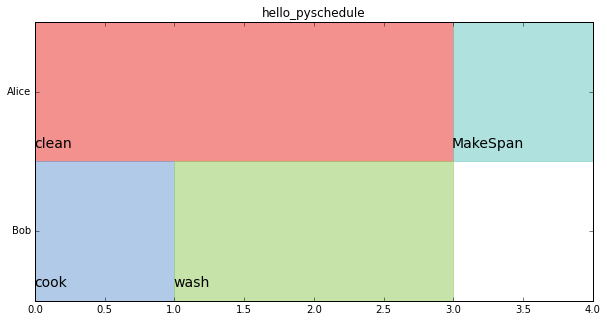

In [2]:
%matplotlib inline
plotters.matplotlib.plot(S,fig_size=(10,5))

pyschedule supports different solvers, classical <a href="https://en.wikipedia.org/wiki/Integer_programming">MIP</a>- as well as <a href="https://en.wikipedia.org/wiki/Constraint_programming">CP</a>-based ones. All solvers and their capabilities are listed in the <a href="https://github.com/timnon/pyschedule/blob/master/docs/pyschedule-overview.md">overview notebook</a>. The default solver used above uses a standard MIP-model in combination with <a href="https://projects.coin-or.org/Cbc">CBC</a>, which is part of package <a href="https://pypi.python.org/pypi/PuLP">pulp</a>. If you have CPLEX installed (command "cplex" must be running), you can easily switch to CPLEX using:


In [ ]:
solvers.mip.solve(S,kind='CPLEX')

pyschedule is under active development, there might be non-backward-compatible changes. More base features are explained in the following example.

# Alice and Bob optimize their bike paint shop with pyschedule

Alice and Bob are running a paint shop for bikes where they pimp bikes with fresh colors. Today they have to paint a green and a red bike. To get started they import pyschedule and create a new scenario. We use hours as granularity and expect a working day of at most 10 hours, so we set the planning horizon to 10. Some solvers do not need this parameter, but the default solver requires it:

In [3]:
from pyschedule import Scenario, solvers, plotters
S = Scenario('bike_paint_shop', horizon=10)

Then they create themselves as resources:

In [4]:
Alice = S.Resource('Alice')
Bob = S.Resource('Bob')

Painting a bike takes two hours. Moreover, after the bike has been painted, it needs to get post-processed (e.g. tires pumped) which takes one hour (which is the default). This translates into four tasks in total:

In [5]:
green_paint, red_paint = S.Task('green_paint', length=2), S.Task('red_paint', length=2)
green_post, red_post = S.Task('green_post'), S.Task('red_post')

Clearly, one can only do the post-processing after the painting with an arbitrary gap in between. For the red paint we are a little stricter, here we want to start the post-processing exactly one hour after the painting since this is the time the color takes to dry:

In [6]:
S += green_paint < green_post, red_paint + 1 <= red_post

Each task can be done by either Alice or Bob. Note that we use the %-operator to assign resources to tasks:

In [7]:
green_paint += Alice|Bob
green_post += Alice|Bob

red_paint += Alice|Bob
red_post += Alice|Bob

So lets have a look at the scenario:

In [8]:
S.clear_solution()
print(S)

###############################################

SCENARIO: bike_paint_shop / horizon: 10

OBJECTIVE: None

RESOURCES:
Alice
Bob

TASKS:
green_paint : Alice|Bob
red_paint : Alice|Bob
green_post : Alice|Bob
red_post : Alice|Bob

JOINT RESOURCES:
Alice|Bob : red_paint
Alice|Bob : red_post
Alice|Bob : green_paint
Alice|Bob : green_post

LAX PRECEDENCES:
green_paint < green_post

TIGHT PRECEDENCES:
red_paint + 1 <= red_post

###############################################


We havent defined an objective yet, lets use the MakeSpan and check the scenario again:

In [9]:
S.use_makespan_objective()
print(S)

###############################################

SCENARIO: bike_paint_shop / horizon: 10

OBJECTIVE: MakeSpan

RESOURCES:
Alice
Bob

TASKS:
green_paint : Alice|Bob
red_paint : Alice|Bob
green_post : Alice|Bob
red_post : Alice|Bob
MakeSpan : Alice

JOINT RESOURCES:
Alice|Bob : red_paint
Alice|Bob : red_post
Alice|Bob : green_paint
Alice|Bob : green_post

LAX PRECEDENCES:
green_paint < green_post
green_paint < MakeSpan
red_paint < MakeSpan
green_post < MakeSpan
red_post < MakeSpan

TIGHT PRECEDENCES:
red_paint + 1 <= red_post

###############################################


Hence, we want to minimize the position of the MakeSpan task subject to the constraint that it is scheduled after all other tasks. Thus, the position of the MakeSpan is the length of our schedule. Now we have the first version of our scenario, lets solve and plot it:

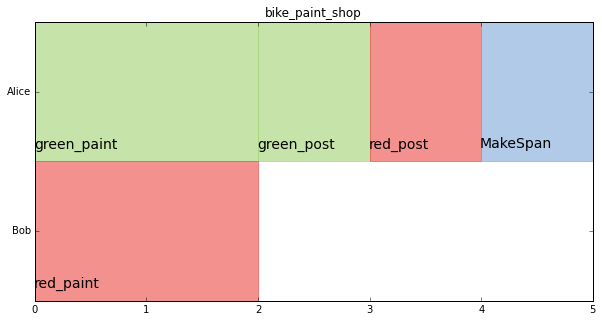

In [10]:
# Set some colors for the tasks
task_colors = { green_paint   : '#A1D372',
                green_post    : '#A1D372', 
                red_paint     : '#EB4845',
                red_post      : '#EB4845',
                S['MakeSpan'] : '#7EA7D8'}

# A small helper method to solve and plot a scenario
def run(S) :
    if solvers.mip.solve(S):
        %matplotlib inline
        plotters.matplotlib.plot(S,task_colors=task_colors,fig_size=(10,5))
    else:
        print('no solution exists')
run(S)

Bob is annoyed, if he paints the red bike, he also wants to do the post-processing, switching bikes takes too much time. We use the following constraints to ensure this. They ensure that painting and post-processing the red bike will both be done by either Alice or Bob. The same holds for the green one:

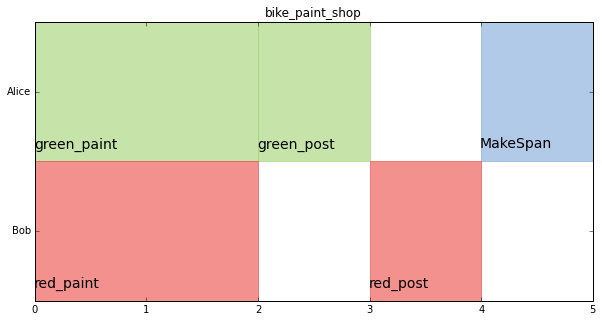

In [11]:
# First remove the old resource to task assignments
green_paint -= Alice|Bob
green_post -= Alice|Bob
red_paint -= Alice|Bob
red_post -= Alice|Bob

# Add new shared ones
green_resource = Alice|Bob
green_paint += green_resource
green_post += green_resource

red_resource = Alice|Bob
red_paint += red_resource
red_post += red_resource
run(S)

This schedule completes after four hours and suggests to paint both bikes at the same time. However, Alice and Bob have only a single paint shop which they need to share:

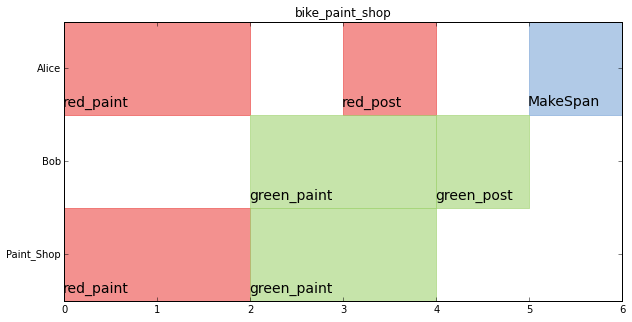

In [12]:
Paint_Shop = S.Resource('Paint_Shop')
red_paint += Paint_Shop
green_paint += Paint_Shop
run(S)

Great, everybody can still go home after five hours and have a late lunch! Unfortunately, Alice receives a call that the red bike will only arrive after two hours:

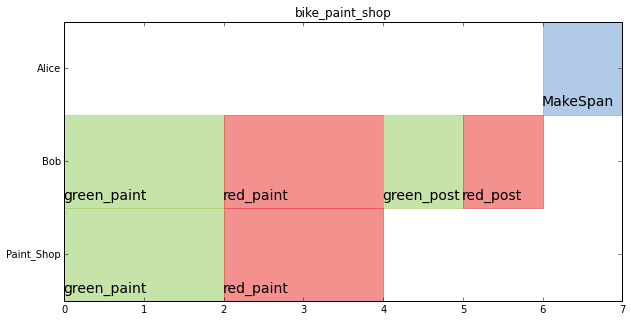

In [13]:
S += red_paint > 2
run(S)

Too bad, everything takes now size hours to finish. Therefore Alica and Bob decide to schedule a lunch after the third hour and before the fifth hour:

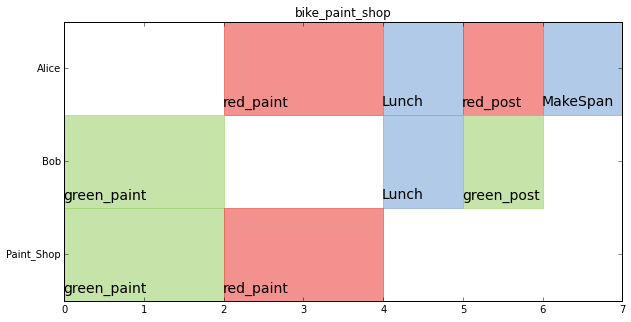

In [14]:
Lunch = S.Task('Lunch')
Lunch += {Alice, Bob}
S += Lunch > 3, Lunch < 5
task_colors[Lunch] = '#7EA7D8'
run(S)

Finally, Alice is a morning person and  wants to finish three hours of work before lunch, that is, before the third hour:

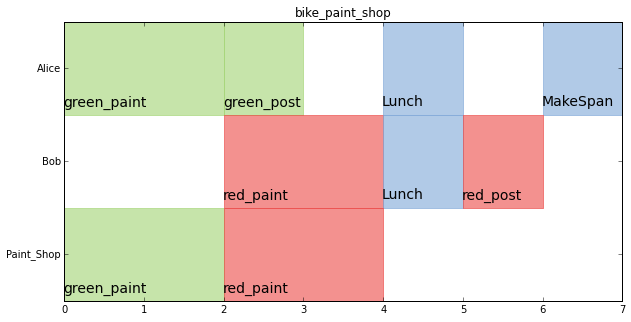

In [15]:
S += Alice['length'][:3] >= 3
run(S)

All this sounds quite trivial, but think about the same problem with many bikes and many persons!